In [18]:
import torch 
from hnet.train.hnet import train_hnet
import pandas as pd 
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import r2_score
from hnet.models.MLP import MLP 
from hnet.models.HyperNet import HyperNet
from hnet.train.hnet import EnergyDistanceLoss 
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import roc_auc_score

from tkgdti.embed.AA2EMB import AA2EMB
from tkgdti.embed.SMILES2EMB import SMILES2EMB

In [19]:
tdf = pd.read_csv('../../extdata/meta/targetome__drug_targets_gene.csv')
aadf = pd.read_csv('../../extdata/meta/gene2aa.csv')
tdf.head()

,inhibitor,Symbol,GeneID,targetome_adj_tier,can_smiles,inchikey,iso_smiles
0,ABT-737,BAD,572,TIER_1,CN(C)CCC(CSC1=CC=CC=C1)NC2=C(C=C(C=C2)S(=O)(=O...,HPLNQCPCUACXLM-PGUFJCEWSA-N,CN(C)CC[C@H](CSC1=CC=CC=C1)NC2=C(C=C(C=C2)S(=O...
1,Palbociclib,CCND1,595,TIER_1,CC1=C(C(=O)N(C2=NC(=NC=C12)NC3=NC=C(C=C3)N4CCN...,AHJRHEGDXFFMBM-UHFFFAOYSA-N,CC1=C(C(=O)N(C2=NC(=NC=C12)NC3=NC=C(C=C3)N4CCN...
2,Flavopiridol,CCNT1,904,TIER_1,CN1CCC(C(C1)O)C2=C(C=C(C3=C2OC(=CC3=O)C4=CC=CC...,BIIVYFLTOXDAOV-YVEFUNNKSA-N,CN1CC[C@@H]([C@@H](C1)O)C2=C(C=C(C3=C2OC(=CC3=...
3,Bortezomib (Velcade),PSMA1,5682,TIER_1,B(C(CC(C)C)NC(=O)C(CC1=CC=CC=C1)NC(=O)C2=NC=CN...,GXJABQQUPOEUTA-RDJZCZTQSA-N,B([C@H](CC(C)C)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)...
4,Bortezomib (Velcade),PSMA2,5683,TIER_1,B(C(CC(C)C)NC(=O)C(CC1=CC=CC=C1)NC(=O)C2=NC=CN...,GXJABQQUPOEUTA-RDJZCZTQSA-N,B([C@H](CC(C)C)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)...


In [20]:
# TODO: retrieve canonical smiles from pubchem

In [21]:
smiles = tdf['can_smiles'].unique().astype(str).tolist()
aas = aadf['sequence'].unique().astype(str).tolist()

In [22]:
smiles2idx = {smile: i for i, smile in enumerate(smiles)}
aas2idx = {aa: i for i, aa in enumerate(aas)}
gene2aas = {gene: aas for gene, aas in zip(aadf.gene_name, aadf.sequence)}
gene2idx = lambda gene: aas2idx[gene2aas[gene]]

tdf = tdf.assign(drug_idx=tdf.can_smiles.map(smiles2idx))
tdf = tdf.assign(prot_idx=tdf.Symbol.map(gene2idx))
tdf.head()

,inhibitor,Symbol,GeneID,targetome_adj_tier,can_smiles,inchikey,iso_smiles,drug_idx,prot_idx
0,ABT-737,BAD,572,TIER_1,CN(C)CCC(CSC1=CC=CC=C1)NC2=C(C=C(C=C2)S(=O)(=O...,HPLNQCPCUACXLM-PGUFJCEWSA-N,CN(C)CC[C@H](CSC1=CC=CC=C1)NC2=C(C=C(C=C2)S(=O...,0,1069
1,Palbociclib,CCND1,595,TIER_1,CC1=C(C(=O)N(C2=NC(=NC=C12)NC3=NC=C(C=C3)N4CCN...,AHJRHEGDXFFMBM-UHFFFAOYSA-N,CC1=C(C(=O)N(C2=NC(=NC=C12)NC3=NC=C(C=C3)N4CCN...,1,1579
2,Flavopiridol,CCNT1,904,TIER_1,CN1CCC(C(C1)O)C2=C(C=C(C3=C2OC(=CC3=O)C4=CC=CC...,BIIVYFLTOXDAOV-YVEFUNNKSA-N,CN1CC[C@@H]([C@@H](C1)O)C2=C(C=C(C3=C2OC(=CC3=...,2,1592
3,Bortezomib (Velcade),PSMA1,5682,TIER_1,B(C(CC(C)C)NC(=O)C(CC1=CC=CC=C1)NC(=O)C2=NC=CN...,GXJABQQUPOEUTA-RDJZCZTQSA-N,B([C@H](CC(C)C)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)...,3,9065
4,Bortezomib (Velcade),PSMA2,5683,TIER_1,B(C(CC(C)C)NC(=O)C(CC1=CC=CC=C1)NC(=O)C2=NC=CN...,GXJABQQUPOEUTA-RDJZCZTQSA-N,B([C@H](CC(C)C)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)...,3,9066


In [23]:
S2E = SMILES2EMB()
z_drug = S2E.embed(smiles)

In [24]:
AA2E = AA2EMB()
z_prot = AA2E.embed(aas)

In [25]:
model = torch.load('../../output/kd/model.pt').cpu()

/tmp/ipykernel_3558/3300617903.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('../../output/kd/model.pt').cpu()


In [26]:
smiles2inchi = {smile: inchi for smile, inchi in zip(tdf.can_smiles, tdf.inchikey)}
aa2gene = {aa: gene for aa, gene in zip(aadf.sequence, aadf.gene_name)}

In [27]:
res = {'drug_idx': [], 'prot_idx': [], 'inchikey': [], 'gene_symbol': []}

for i in range(len(smiles)): 
    for j in range(len(aas)):
        res['drug_idx'].append(i)
        res['prot_idx'].append(j)
        gene = aa2gene[aas[j]]
        inchi = smiles2inchi[smiles[i]]
        res['inchikey'].append(inchi)
        res['gene_symbol'].append(gene)

res = pd.DataFrame(res).merge(tdf[['prot_idx', 'drug_idx']].assign(in_targetome=True), on=['prot_idx', 'drug_idx'], how='left').fillna(False)
print(res.shape)
res.head()

(1158157, 5)


/tmp/ipykernel_3558/2427235751.py:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  res = pd.DataFrame(res).merge(tdf[['prot_idx', 'drug_idx']].assign(in_targetome=True), on=['prot_idx', 'drug_idx'], how='left').fillna(False)


,drug_idx,prot_idx,inchikey,gene_symbol,in_targetome
0,0,0,HPLNQCPCUACXLM-PGUFJCEWSA-N,A1BG,False
1,0,1,HPLNQCPCUACXLM-PGUFJCEWSA-N,A1CF,False
2,0,2,HPLNQCPCUACXLM-PGUFJCEWSA-N,A2M,False
3,0,3,HPLNQCPCUACXLM-PGUFJCEWSA-N,A3GALT2,False
4,0,4,HPLNQCPCUACXLM-PGUFJCEWSA-N,A4GALT,False


In [32]:
y_pred = []
lcb_pred = []
ucb_pred = []
for i in range(0, len(res), 1000):
    print(f'progress: {i}/{len(res)}', end='\r')
    z_drug_batch = z_drug[res.drug_idx.values[i:i+1000]]
    z_prot_batch = z_prot[res.prot_idx.values[i:i+1000]]
    zz = torch.cat([z_drug_batch, z_prot_batch], dim=1)
    preds = model(zz, samples=100).detach().cpu().numpy()
    y_pred.append( preds.mean(0) )
    lcb_pred.append( np.quantile(preds, q=0.05, axis=0) )
    ucb_pred.append( np.quantile(preds, q=0.95, axis=0) )
y_pred = np.concatenate(y_pred)
lcb_pred = np.concatenate(lcb_pred)
ucb_pred = np.concatenate(ucb_pred)


In [33]:
res = res.assign(kd_score=y_pred, kd_lcb=lcb_pred, kd_ucb=ucb_pred)
res.head()

,drug_idx,prot_idx,inchikey,gene_symbol,in_targetome,kd_score,kd_lcb,kd_ucb
0,0,0,HPLNQCPCUACXLM-PGUFJCEWSA-N,A1BG,False,-0.631237,-2.087436,1.409813
1,0,1,HPLNQCPCUACXLM-PGUFJCEWSA-N,A1CF,False,-0.677140,-1.780508,1.364411
2,0,2,HPLNQCPCUACXLM-PGUFJCEWSA-N,A2M,False,-0.606264,-1.967222,1.569811
3,0,3,HPLNQCPCUACXLM-PGUFJCEWSA-N,A3GALT2,False,-0.743567,-2.083765,0.695713
4,0,4,HPLNQCPCUACXLM-PGUFJCEWSA-N,A4GALT,False,-0.678936,-1.923692,0.806777


In [34]:
res.to_csv('../../output/kd/predictions.csv', index=False)

In [14]:
roc_auc_score(res.in_targetome, res.kd_score)

0.7124459822749589

In [1]:
plt.figure()
plt.hist(res[lambda x: x.in_targetome].kd_score, bins=25, alpha=0.25, density=True, color='r', label='targetome')
plt.hist(res[lambda x: ~x.in_targetome].kd_score, bins=100, alpha=0.25, density=True, color='b', label='non-targetome')
plt.xlabel('KD score')
plt.legend()
plt.show()

NameError: name 'plt' is not defined

In [16]:
didx, pidx = torch.ones((len(smiles), len(aas))).nonzero(as_tuple=True)

drug_idx = torch.tensor(tdf.drug_idx.values, dtype=torch.long)
prot_idx = torch.tensor(tdf.prot_idx.values, dtype=torch.long)
A = torch.zeros(len(smiles), len(aas), dtype=torch.bool)
A[drug_idx, prot_idx] = True

y = A[didx, pidx].float()

len(y)

1158157

In [ ]:


yhat_mu = []
yhat_lcb = []
yhat_ucb = []
for i in range(0, len(y), 1000):
    print(f'progress: {i/len(y):.2f}', end='\r')
    with torch.no_grad(): 
        zz = torch.cat((z_drug[didx[i:i+1000]], z_prot[pidx[i:i+1000]]), dim=1)
        yhat = model(zz, samples=100)
        yhat_mu.append( yhat.mean(dim=0) ) 
        yhat_lcb.append( torch.quantile(yhat, 0.025, dim=0) )
        yhat_ucb.append( torch.quantile(yhat, 0.975, dim=0) )

yhat_mu = torch.cat(yhat_mu)
yhat_lcb = torch.cat(yhat_lcb)
yhat_ucb = torch.cat(yhat_ucb)



KeyboardInterrupt: 

In [37]:
idx2smiles = {v: k for k, v in smiles2idx.items()}
smiles2inchi = {row.smiles:row.inchikey for i,row in tdf[['smiles', 'inchikey']].drop_duplicates().iterrows()}
idx2inchi = lambda x: smiles2inchi[idx2smiles[x]]

idx2aa = {v: k for k, v in aas2idx.items()}
aa2gene = {row.AA:row.Symbol for i,row in tdf[['AA', 'Symbol']].drop_duplicates().iterrows()}
idx2gene = lambda x: aa2gene[idx2aa[x]]

In [45]:
res = pd.DataFrame({'targetome': np.array([False, True])[y.long().numpy()], 
                    'score_mean': yhat_mu.squeeze().numpy(), 
                    'score_lcb': yhat_lcb.squeeze().numpy(),
                    'score_ucb': yhat_ucb.squeeze().numpy(),
                    'drug': [idx2inchi(i) for i in didx.numpy()], 
                    'gene': [idx2gene(i) for i in pidx.numpy()]})

res.head()

,targetome,score_mean,score_lcb,score_ucb,drug,gene
0,True,-1.352746,-3.399308,0.047438,HPLNQCPCUACXLM-PGUFJCEWSA-N,BAD
1,False,-0.753388,-2.351048,0.996499,HPLNQCPCUACXLM-PGUFJCEWSA-N,CCND1
2,False,-0.890982,-2.702962,1.091414,HPLNQCPCUACXLM-PGUFJCEWSA-N,CCNT1
3,False,-1.218118,-2.903158,0.693510,HPLNQCPCUACXLM-PGUFJCEWSA-N,PSMA1
4,False,-1.198125,-2.993247,0.658259,HPLNQCPCUACXLM-PGUFJCEWSA-N,PSMA2


In [50]:
roc_auc_score(res.targetome*1., res.score_mean)

0.5918003422175534

In [55]:

# select top 10% 
high_binders = res[lambda x: x.score_mean > x.score_mean.quantile(0.8)]

# select bottom 10%
low_binders = res[lambda x: x.score_mean < x.score_mean.quantile(0.2)]

# print num of high binders
print(len(high_binders))
print(len(low_binders))

3809
3809


In [58]:
strong_binding_fwd = high_binders.rename({'drug':'src', 'gene':'dst'}, axis=1).assign(src_type='drug', dst_type='gene', relation='predicted_strong_binding_fwd')[['src', 'dst', 'src_type', 'dst_type', 'relation']]
strong_binding_rev = high_binders.rename({'drug':'dst', 'gene':'src'}, axis=1).assign(src_type='gene', dst_type='drug', relation='predicted_strong_binding_rev')[['src', 'dst', 'src_type', 'dst_type', 'relation']]

weak_binding_fwd = low_binders.rename({'drug':'src', 'gene':'dst'}, axis=1).assign(src_type='drug', dst_type='gene', relation='predicted_weak_binding_fwd')[['src', 'dst', 'src_type', 'dst_type', 'relation']]
weak_binding_rev = low_binders.rename({'drug':'dst', 'gene':'src'}, axis=1).assign(src_type='gene', dst_type='drug', relation='predicted_weak_binding_rev')[['src', 'dst', 'src_type', 'dst_type', 'relation']]

strong_binding_fwd.to_csv('../../extdata/relations/jglaser_predicted_strong_binding_fwd.csv', index=False)
strong_binding_rev.to_csv('../../extdata/relations/jglaser_predicted_strong_binding_rev.csv', index=False)
weak_binding_fwd.to_csv('../../extdata/relations/jglaser_predicted_weak_binding_fwd.csv', index=False)
weak_binding_rev.to_csv('../../extdata/relations/jglaser_predicted_weak_binding_rev.csv', index=False)

In [ ]:
res.

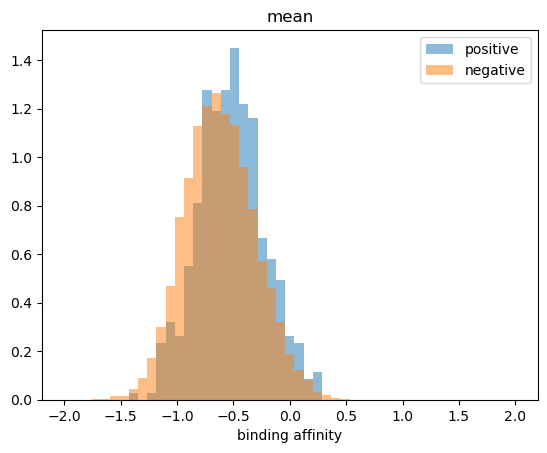

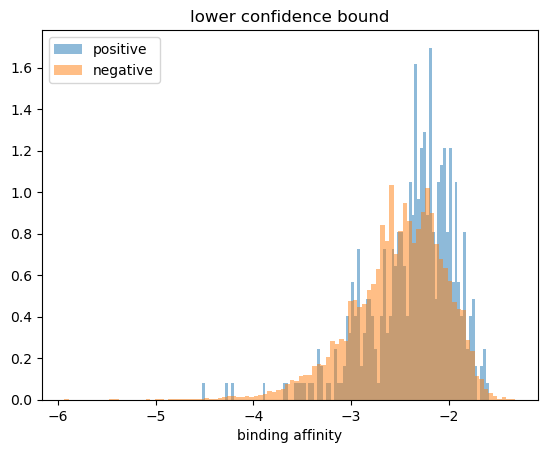

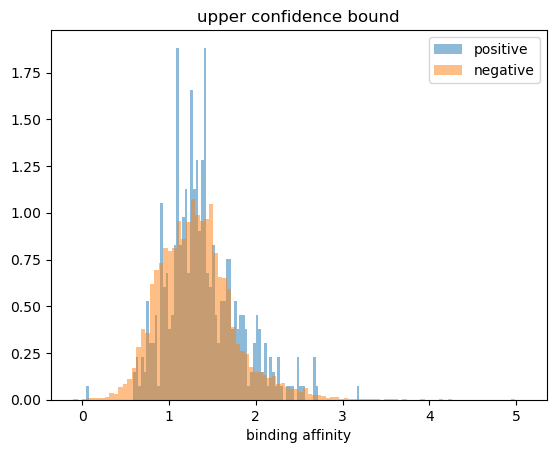

In [53]:
# -1 ~ 1uM 
_bins = np.linspace(-2, 2, 50)

plt.figure()
plt.title('mean')
plt.hist(res[lambda x: x.targetome].score_mean.values, bins=_bins, alpha=0.5, label='positive', density=True)
plt.hist(res[lambda x: ~x.targetome].score_mean.values, bins=_bins, alpha=0.5, label='negative', density=True)
plt.xlabel('binding affinity')
plt.legend()
plt.show()

plt.figure()
plt.title('lower confidence bound')
plt.hist(res[lambda x: x.targetome].score_lcb.values, bins=100, alpha=0.5, label='positive', density=True)
plt.hist(res[lambda x: ~x.targetome].score_lcb.values, bins=100, alpha=0.5, label='negative', density=True)
plt.xlabel('binding affinity')
plt.legend()
plt.show()

plt.figure()
plt.title('upper confidence bound')
plt.hist(res[lambda x: x.targetome].score_ucb.values, bins=100, alpha=0.5, label='positive', density=True)
plt.hist(res[lambda x: ~x.targetome].score_ucb.values, bins=100, alpha=0.5, label='negative', density=True)
plt.xlabel('binding affinity')
plt.legend()
plt.show()

In [ ]:
#rand_drug_idx = torch.randint(0, len(smiles), size=(1000,), dtype=torch.long)
#rand_prot_idx = torch.randint(0, len(aas), size=(1000,), dtype=torch.long)

drug_idx = torch.tensor(tdf.drug_idx.values, dtype=torch.long)
prot_idx = torch.tensor(tdf.prot_idx.values, dtype=torch.long)

A = torch.zeros(len(smiles), len(aas), dtype=torch.bool)
A[drug_idx, prot_idx] = True
Anot = ~(A)
neg_drug_idx, neg_prot_idx = Anot.nonzero(as_tuple=True)

x_pos = torch.cat([z_drug[drug_idx], z_prot[prot_idx]], dim=1).float()
x_neg = torch.cat([z_drug[neg_drug_idx], z_prot[neg_prot_idx]], dim=1).float()

print('# positive samples:', len(x_pos))
print('# negative samples:', len(x_neg))

y = torch.cat([torch.ones(len(tdf)), torch.zeros(x_neg.size(0))], dim=0).float()

with torch.no_grad(): 
    yhat_pos = model(x_pos, samples=250)
    yhat_neg = model(x_neg, samples=250)

yhat = torch.cat([yhat_pos, yhat_neg], dim=1)

# positive samples: 422
# negative samples: 18624


In [26]:
auc = roc_auc_score(y.detach().numpy(), yhat.mean(0).detach().numpy())
print(f'AUC: {auc}')

AUC: 0.6581709021432876


In [ ]:
# confusion matrix 
cls = y > 0 
phat = (yhat > 0).mean(0).squeeze() 


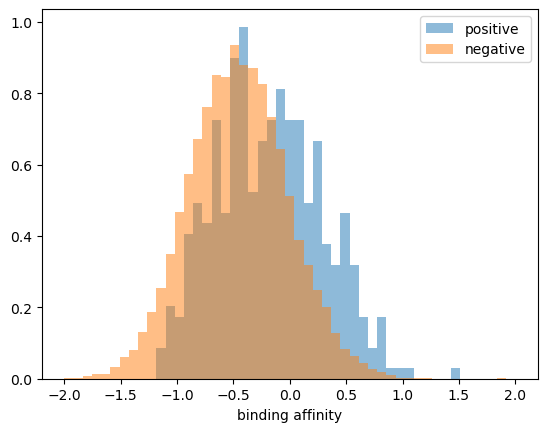

In [24]:
# -1 ~ 1uM 
_bins = np.linspace(-2, 2, 50)

plt.figure()
plt.hist(yhat_pos.cpu().mean(dim=0).numpy(), bins=_bins, alpha=0.5, label='positive', density=True)
plt.hist(yhat_neg.cpu().mean(dim=0).numpy(), bins=_bins, alpha=0.5, label='negative', density=True)
plt.xlabel('binding affinity')
plt.legend()
plt.show()

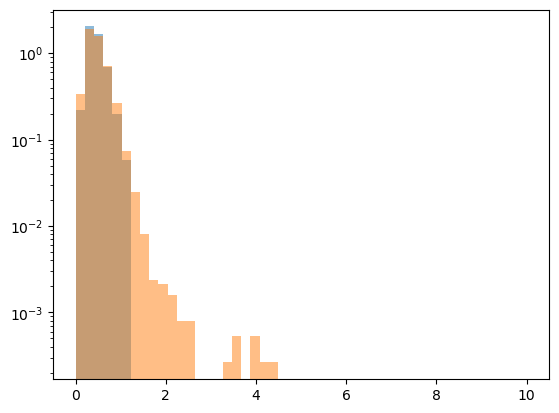

In [14]:
var_pos = yhat_pos.var(dim=0)
var_neg = yhat_neg.var(dim=0)

_bins = np.linspace(0,10, 50)
plt.figure()
plt.hist(var_pos.cpu().numpy(), bins=_bins, label='positive', alpha=0.5, density=True)
plt.hist(var_neg.cpu().numpy(), bins=_bins, label='negative', alpha=0.5, density=True)
plt.yscale('log')
plt.show()

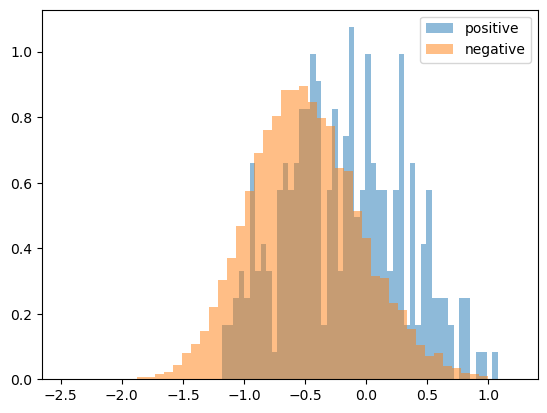

In [21]:
var = yhat.var(dim=0).squeeze()
hi_conf_mask = var < 0.5

y_hi_conf = y[hi_conf_mask]
yhat_hi_conf = yhat.mean(0)[hi_conf_mask]

plt.figure()
plt.hist(yhat_hi_conf[y_hi_conf.bool()].cpu().numpy(), bins=50, alpha=0.5, label='positive', density=True)
plt.hist(yhat_hi_conf[~y_hi_conf.bool()].cpu().numpy(), bins=50, alpha=0.5, label='negative', density=True)
plt.legend()
plt.show()

In [22]:
auc = roc_auc_score(y_hi_conf.detach().numpy(), yhat_hi_conf.detach().numpy())
print(f'AUC: {auc}')

AUC: 0.6788555276576618


In [26]:
phat = (yhat > 0).float().mean(0)
roc_auc_score(y.detach().numpy(), phat.detach().numpy())

0.6301624642717545

In [15]:
# kiba 
kiba = pd.read_csv('../../extdata/kiba/kiba.csv')
kiba.head()

,CHEMBLID,ProteinID,compound_iso_smiles,target_sequence,"Ki , Kd and IC50 (KIBA Score)",drug_idx,prot_idx
0,CHEMBL373751,P53350,COC1=C(C=C2C(=C1)N=CN2C3=CC(=C(S3)C#N)OCC4=CC=...,MSAAVTAGKLARAPADPGKAGVPGVAAPGAPAAAPPAKEIPEVLVD...,0.0,0,0
1,CHEMBL373751,P00533,COC1=C(C=C2C(=C1)N=CN2C3=CC(=C(S3)C#N)OCC4=CC=...,MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFED...,1.1,0,1
2,CHEMBL373751,P04626,COC1=C(C=C2C(=C1)N=CN2C3=CC(=C(S3)C#N)OCC4=CC=...,MELAALCRWGLLLALLPPGAASTQVCTGTDMKLRLPASPETHLDML...,1.1,0,2
3,CHEMBL373751,P49840,COC1=C(C=C2C(=C1)N=CN2C3=CC(=C(S3)C#N)OCC4=CC=...,MSGGGPSGGGPGGSGRARTSSFAEPGGGGGGGGGGPGGSASGPGGT...,1.3,0,3
4,CHEMBL373751,P49841,COC1=C(C=C2C(=C1)N=CN2C3=CC(=C(S3)C#N)OCC4=CC=...,MSGRPRTTSFAESCKPVQQPSAFGSMKVSRDKDGSKVTTVVATPGQ...,1.3,0,4


In [16]:
z_drug = torch.load('../../extdata/kiba/z_drug.pt')
z_prot = torch.load('../../extdata/kiba/z_prot.pt')

/tmp/ipykernel_805/4234575712.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  z_drug = torch.load('../../extdata/kiba/z_drug.pt')
/tmp/ipykernel_805/4234575712.py:2: Fut

In [17]:
kiba = kiba.assign(neg_lgo10_uM = -np.log(kiba['Ki , Kd and IC50  (KIBA Score)'] + 1e-10))
mu = kiba['neg_lgo10_uM'].mean()
sigma = kiba['neg_lgo10_uM'].std()
kiba = kiba.assign(binding_affinity = (kiba['neg_lgo10_uM'] - mu) / (sigma + 1e-8))

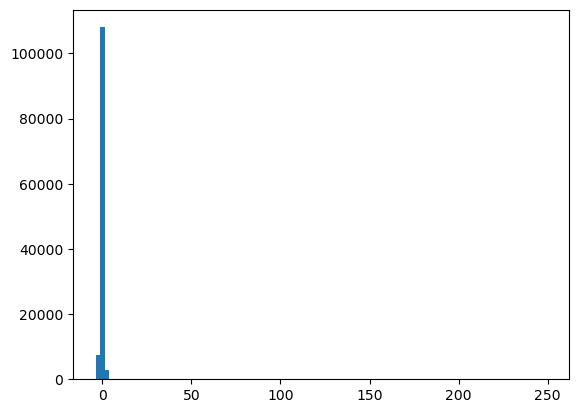

In [18]:
plt.figure()
plt.hist(kiba['binding_affinity'], bins=100)
plt.show()

In [19]:
drug_idx = torch.tensor(kiba.drug_idx.values, dtype=torch.long)
prot_idx = torch.tensor(kiba.prot_idx.values, dtype=torch.long)

x = torch.cat([z_drug[drug_idx], z_prot[prot_idx]], dim=1)
#y = torch.tensor(kiba.binding_affinity.values, dtype=torch.float32).view(-1, 1)
y = torch.tensor(kiba['Ki , Kd and IC50  (KIBA Score)'], dtype=torch.float32)

In [20]:
with torch.no_grad(): 
    y_pred = model.cuda()(x.cuda(), samples=100).squeeze()

In [21]:
np.corrcoef(y.cpu().numpy().ravel(), y_pred.mean(0).cpu().numpy().ravel())[0,1]

KeyboardInterrupt: 

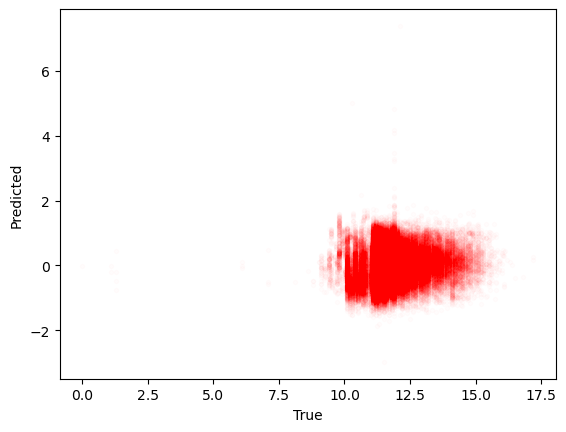

In [ ]:
plt.figure()
plt.plot(y.cpu().numpy(), y_pred.mean(0).cpu().numpy(), 'r.', alpha=0.01)
#plt.xlim(-5, 5)
#plt.ylim(-5, 5)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.show()

In [ ]:
affin = load_dataset("jglaser/binding_affinity",split='train[:90%]').to_pandas()

In [ ]:
kiba_smiles = kiba['compound_iso_smiles'].unique() 
jglaser_smiles = affin['smiles_can'].unique()

overlap_smiles = np.intersect1d(kiba_smiles, jglaser_smiles)
len(overlap)

1

In [ ]:
kiba_aas = kiba['target_sequence'].unique()
jglaser_aas = affin['seq'].unique()

overlap_aas = np.intersect1d(kiba_aas, jglaser_aas)
len(overlap_aas)

224

In [ ]:
affin.head()

,seq,smiles,affinity_uM,neg_log10_affinity_M,smiles_can,affinity
0,MTVPDRSEIAGKWYVVALASNTEFFLREKDKMKMAMARISFLGEDE...,CCCCCCCCCCCCCCCCCCCC(=O)O,0.026,7.585027,CCCCCCCCCCCCCCCCCCCC(=O)O,0.691712
1,APQTITELCSEYRNTQIYTINDKILSYTESMAGKREMVIITFKSGE...,OC[C@H]1O[C@H](Oc2cccc(c2)N(=O)=O)[C@@H]([C@H]...,500.000,3.301030,O=[N+]([O-])c1cccc(O[C@H]2O[C@H](CO)[C@H](O)[C...,-2.054668
2,VETFAFQAEIAQLMSLIINTFYSNKEIFLRELISNSSDALDKIRYE...,COc1ccc(cc1)c1c(onc1c1cc(C(C)C)c(cc1O)O)NC(=O)...,0.023,7.638272,COc1ccc(-c2c(-c3cc(C(C)C)c(O)cc3O)noc2NC(=O)C2...,0.725847
3,AAPFDKSKNVAQSIDQLIGQTPALYLNKLNNTKAKVVLKMECENPM...,OC[C@@H](C(=O)N[C@@H]([C@H](CC)C)C(=O)O)NC(=O)...,6.430,5.191789,CC[C@H](C)[C@H](NC(=O)[C@H](CO)NC(=O)[C@H](CC1...,-0.842542
4,YITFRSFTAVLIAFFLTLVLSPSFINRLRKIQRKKYTPTMGGIVIL...,CO[C@@H]1[C@H](O[C@H]([C@@H]1O)n1ccc(=O)[nH]c1...,0.185,6.732828,CO[C@@H]1[C@@H]([C@@H](O[C@H]2OC(C(=O)N[C@H]3C...,0.145386


In [ ]:
kiba.head()

,CHEMBLID,ProteinID,compound_iso_smiles,target_sequence,"Ki , Kd and IC50 (KIBA Score)",drug_idx,prot_idx,neg_lgo10_uM,binding_affinity
0,CHEMBL373751,P53350,COC1=C(C=C2C(=C1)N=CN2C3=CC(=C(S3)C#N)OCC4=CC=...,MSAAVTAGKLARAPADPGKAGVPGVAAPGAPAAAPPAKEIPEVLVD...,0.0,0,0,23.025851,249.303756
1,CHEMBL373751,P00533,COC1=C(C=C2C(=C1)N=CN2C3=CC(=C(S3)C#N)OCC4=CC=...,MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFED...,1.1,0,1,-0.095310,23.119186
2,CHEMBL373751,P04626,COC1=C(C=C2C(=C1)N=CN2C3=CC(=C(S3)C#N)OCC4=CC=...,MELAALCRWGLLLALLPPGAASTQVCTGTDMKLRLPASPETHLDML...,1.1,0,2,-0.095310,23.119186
3,CHEMBL373751,P49840,COC1=C(C=C2C(=C1)N=CN2C3=CC(=C(S3)C#N)OCC4=CC=...,MSGGGPSGGGPGGSGRARTSSFAEPGGGGGGGGGGPGGSASGPGGT...,1.3,0,3,-0.262364,21.484966
4,CHEMBL373751,P49841,COC1=C(C=C2C(=C1)N=CN2C3=CC(=C(S3)C#N)OCC4=CC=...,MSGRPRTTSFAESCKPVQQPSAFGSMKVSRDKDGSKVTTVVATPGQ...,1.3,0,4,-0.262364,21.484966


In [ ]:
df = affin.merge(kiba, left_on=['smiles_can', 'seq'], right_on=['compound_iso_smiles', 'target_sequence'], how='inner')
df

,seq,smiles,affinity_uM,neg_log10_affinity_M,smiles_can,affinity,CHEMBLID,ProteinID,compound_iso_smiles,target_sequence,"Ki , Kd and IC50 (KIBA Score)",drug_idx,prot_idx,neg_lgo10_uM,binding_affinity
0,MSDVAIVKEGWLHKRGEYIKTWRPRYFLLKNDGTFIGYKERPQDVD...,CCCCCCCCCCCCCCCCCCOCC(COP([O-])(=O)OCC[N+](C)(...,3.5,5.455932,CCCCCCCCCCCCCCCCCCOCC(COP(=O)([O-])OCC[N+](C)(...,-0.673205,CHEMBL28509,P31749,CCCCCCCCCCCCCCCCCCOCC(COP(=O)([O-])OCC[N+](C)(...,MSDVAIVKEGWLHKRGEYIKTWRPRYFLLKNDGTFIGYKERPQDVD...,11.555932,798,76,-2.447199,0.11165
